
# TP — Tokenization, Préprocessing et Impact sur un WordCloud (Avis clients)


Objectifs:
- Tokenization **caractères**, **mots**, **sous‑mots (BPE)** avec création du **corpus sous forme de dictionnaire** pour chaque type.
- Pipeline de **préprocessing** (minuscule, accents, URL/mentions/hashtags, nombres, ponctuation, stopwords).
- Visualiser l'**impact du préprocessing** via un pseudo‑WordCloud **avant vs après**.


In [1]:
# Imports
import re, unicodedata, math, random, json, os
from collections import Counter
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)
random.seed(42)

# Chargement du corpus d'avis clients
path = 'data/customer_reviews_fr.txt'
with open(path, 'r', encoding='utf-8') as f:
    docs = [l.strip() for l in f if l.strip()]
len(docs), docs[:3]


(30,
 ['Commande reçue en avance, emballage impeccable. Produit conforme, bon rapport qualité/prix.',
  'Livraison en retard de deux jours et carton abîmé. Le SAV a répondu tardivement.',
  'Excellent aspirateur, silencieux et puissant. Par contre, le manuel est incomplet.'])

## 1) Tokenization par **caractères** et corpus dictionnaire

In [3]:
def tokenize_chars(text: str):
    return list(text)

In [ ]:
# On tokenise les caractères
corpus_chars = {i: tokenize_chars(doc) for i, doc in enumerate(docs)}

In [9]:
tokenized_docs = [tokenize_chars(doc) for doc in docs]

In [11]:
corpus = []
for doc in tokenized_docs:
    corpus.extend(doc)

In [31]:
token2idx = {char: idx for idx, char in enumerate(sorted(set(corpus)))}
idx2token = {idx: char for char, idx in token2idx.items()}
print('Taille vocab caractères:', len(token2idx))

Taille vocab caractères: 63


In [27]:
corpus_ids = [[token2idx[i] for i in doc] for doc in corpus_chars.values()]

## 2) Tokenization par **mots** (regex Unicode) et corpus dictionnaire

### 📝 Explication de la regex WORD_RE

La regex `r"\w+(?:'\w+)?"` avec le flag `re.UNICODE` est spécialement conçue pour le français :

**Décomposition :**
- `\w+` : Correspond à un ou plusieurs caractères "word" (lettres, chiffres, underscore)
- `(?:'\w+)?` : Optionnellement suivi de :
  - `(?:...)` : Groupe non-capturant (ne crée pas de groupe de capture)
  - `'` : Une apostrophe littérale
  - `\w+` : Un ou plusieurs caractères "word" supplémentaires
  - `?` : Rend tout ce groupe optionnel

**Flag UNICODE :** Permet à `\w` de reconnaître les caractères Unicode (accents français : à, é, è, ç, etc.)

**Avantages :**
- ✅ Préserve les contractions françaises : `"aujourd'hui"`, `"J'ai"`, `"C'est"` 
- ✅ Reconnaît les accents : `"café"`, `"très"`, `"naïf"`
- ✅ Traite les mots avec nombres : `"prix123"`

**Limitations :**
- ❌ Une seule apostrophe gérée : `"qu'est-ce"` → `["qu'est", "ce"]`
- ❌ Tirets non supportés : `"c'est-à-dire"` sera fragmenté
- ❌ Emails/URLs fragmentés (mais traités par le préprocessing)

**Comparaison avec regex simple :**
- Regex simple `\w+` : `"aujourd'hui"` → `["aujourd", "hui"]` ❌
- Cette regex : `"aujourd'hui"` → `["aujourd'hui"]` ✅

In [32]:
WORD_RE = re.compile(r"\w+(?:'\w+)?", flags=re.UNICODE)

def tokenize_words(text: str, lower=True):
    if lower:
        text = text.lower()
    return WORD_RE.findall(text)

corpus_words = {i: tokenize_words(doc) for i, doc in enumerate(docs)}
first_id = 0
print(f'doc_id={first_id} | nb_tokens={len(corpus_words[first_id])}')
print('Extrait mots:', corpus_words[first_id][:25])
freq_words = Counter([tok for toks in corpus_words.values() for tok in toks])
print('Top 15 mots:', freq_words.most_common(15))


doc_id=0 | nb_tokens=12
Extrait mots: ['commande', 'reçue', 'en', 'avance', 'emballage', 'impeccable', 'produit', 'conforme', 'bon', 'rapport', 'qualité', 'prix']
Top 15 mots: [('le', 7), ('mais', 7), ('à', 7), ('de', 6), ('et', 6), ('en', 5), ('après', 4), ('a', 3), ('trop', 3), ('la', 3), ("d'attente", 3), ('facture', 3), ('commande', 2), ('reçue', 2), ('bon', 2)]


**Exercice**

1. Calculer le corpus
2. Calculer le vocabulaire
3. transformer chaque commentaire en vecteur de ids.

## 3) Tokenization par **sous‑mots (BPE)** et corpus dictionnaire (version pédagogique)

In [34]:
def tokenize_words_simple(text: str):
    return WORD_RE.findall(text.lower())

def words_with_eow(docs_list):
    words = []
    for d in docs_list:
        for w in tokenize_words_simple(d):
            words.append(list(w) + ['</w>'])
    return words

def get_pair_stats(words):
    pairs = Counter()
    for w in words:
        for i in range(len(w)-1):
            pairs[(w[i], w[i+1])] += 1
    return pairs

def merge_pair(words, pair):
    a, b = pair
    merged = []
    for w in words:
        new_w = []
        i = 0
        while i < len(w):
            if i < len(w)-1 and w[i] == a and w[i+1] == b:
                new_w.append(a+b)
                i += 2
            else:
                new_w.append(w[i])
                i += 1
        merged.append(new_w)
    return merged

def learn_bpe(docs_list, num_merges=60):
    words = words_with_eow(docs_list)
    merges = []
    for _ in range(num_merges):
        pairs = get_pair_stats(words)
        if not pairs:
            break
        best = max(pairs, key=pairs.get)
        if pairs[best] < 2:
            break
        merges.append(best)
        words = merge_pair(words, best)
    return merges

def bpe_tokenize_word(word, merges):
    tokens = list(word) + ['</w>']
    merge_set = set(merges)
    changed = True
    while changed:
        changed = False
        i = 0
        new_toks = []
        while i < len(tokens):
            if i < len(tokens)-1 and (tokens[i], tokens[i+1]) in merge_set:
                new_toks.append(tokens[i] + tokens[i+1])
                i += 2
                changed = True
            else:
                new_toks.append(tokens[i])
                i += 1
        tokens = new_toks
    if tokens and tokens[-1] == '</w>':
        tokens = tokens[:-1]
    return tokens

def bpe_tokenize_doc(doc, merges):
    sub_tokens = []
    for w in tokenize_words_simple(doc):
        sub_tokens.extend(bpe_tokenize_word(w, merges))
    return sub_tokens

merges = learn_bpe(docs, num_merges=60)
print('Nombre de merges appris:', len(merges))
print('Extrait merges:', merges[:15])

corpus_bpe = {i: bpe_tokenize_doc(doc, merges) for i, doc in enumerate(docs)}
first_id = 0
print(f'doc_id={first_id} | nb_subtokens={len(corpus_bpe[first_id])}')
print('Extrait sous-mots:', corpus_bpe[first_id][:30])
freq_bpe = Counter([tok for toks in corpus_bpe.values() for tok in toks])
print('Top 15 sous-mots:', freq_bpe.most_common(15))


Nombre de merges appris: 60
Extrait merges: [('e', '</w>'), ('s', '</w>'), ('o', 'n'), ('t', '</w>'), ('e', 'n'), ('t', 'i'), ('a', 'i'), ('a', 'n'), ('l', 'e</w>'), ('p', 'r'), ('on', '</w>'), ('r', '</w>'), ('i', 'n'), ('t', 'e</w>'), ('r', 'e')]
doc_id=0 | nb_subtokens=51
Extrait sous-mots: ['comm', 'an', 'de</w>', 're', 'ç', 'u', 'e</w>', 'en</w>', 'a', 'v', 'an', 'c', 'e</w>', 'em', 'b', 'al', 'l', 'a', 'g', 'e</w>', 'i', 'm', 'p', 'ec', 'c', 'ab', 'le</w>', 'pro', 'd', 'ui']
Top 15 sous-mots: [('i', 72), ('t', 48), ('s', 46), ('c', 41), ('l', 41), ('p', 37), ('re', 35), ('u', 34), ('r', 30), ('e</w>', 29), ('m', 27), ('n', 27), ('v', 25), ('d', 25), ('s</w>', 25)]


**Exercice**

Prendre un tokenizer déjà entrainé et faire la tokenization.

## 4) Préprocessing — normalisation et stopwords

In [35]:
URL_RE     = re.compile(r'https?://\S+')
MENTION_RE = re.compile(r'@[A-Za-z0-9_]+')
HASHTAG_RE = re.compile(r'#\w+', flags=re.UNICODE)
NUMBER_RE  = re.compile(r'\b\d+[\d.,/]*\b')
PUNCT_RE   = re.compile(r"[\u2000-\u206F\u2E00-\u2E7F\'!\"#$%&()*+,\-./:;<=>?@\[\\\]^_`{|}~]", flags=re.UNICODE)

STOPWORDS_FR = set('''a ai avons avez ont suis es est sommes êtes sont je tu il elle on nous vous ils elles me te se y en du de des un une le la les au aux ce cet cette ces mon ton son ma ta sa mes tes ses notre votre leur nos vos leurs d' l' c' j' n' qu' ne pas plus pour et ou mais donc or ni car comme avec sans sous sur dans par vers entre chez que qui quoi dont où quand comment pourquoi très aussi encore bien mal trop moins même si très tout tous toutes puis parce afin alors'''.split())
STOPWORDS_FR.update({'sav', 'promo', 'commande', 'livraison'})

def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def normalize_text(text, lower=True, rm_accents=True):
    if lower:
        text = text.lower()
    text = URL_RE.sub('<URL>', text)
    text = MENTION_RE.sub('<MENTION>', text)
    text = HASHTAG_RE.sub('<HASHTAG>', text)
    text = NUMBER_RE.sub('<NUM>', text)
    text = PUNCT_RE.sub(' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    if rm_accents:
        text = strip_accents(text)
    return text

def tokenize_words_lower(text):
    return re.findall(r"\w+(?:'\w+)?", text.lower())

def remove_stopwords(tokens, stopwords=STOPWORDS_FR):
    return [t for t in tokens if t not in stopwords]

raw = docs[1]
norm = normalize_text(raw)
print('Avant :', raw)
print('Après  :', norm)
print('Tokens sans stopwords :', remove_stopwords(tokenize_words_lower(norm))[:20])


Avant : Livraison en retard de deux jours et carton abîmé. Le SAV a répondu tardivement.
Après  : livraison en retard de deux jours et carton abime le sav a repondu tardivement
Tokens sans stopwords : ['retard', 'deux', 'jours', 'carton', 'abime', 'repondu', 'tardivement']


## 5) Visualisation — pseudo‑WordCloud **avant vs après**

In [41]:
def top_frequencies_from_dict(corpus_dict, topn=40):
    freq = Counter([tok for toks in corpus_dict.values() for tok in toks])
    return freq.most_common(topn)

top_before = top_frequencies_from_dict(corpus_words, topn=40)
processed_docs = [normalize_text(d) for d in docs]
corpus_words_preproc = {i: tokenize_words_lower(doc) for i, doc in enumerate(processed_docs)}
corpus_words_preproc = {i: remove_stopwords(toks) for i, toks in corpus_words_preproc.items()}
top_after  = top_frequencies_from_dict(corpus_words_preproc, topn=40)

def plot_pseudo_wordcloud(freq_pairs, title):
    theta = 0.0
    r = 0.1
    max_f = max((f for _, f in freq_pairs), default=1)
    plt.axis('off')
    plt.title(title)
    for (w, f) in freq_pairs:
        theta += 0.6; r += 0.08
        x = r * math.cos(theta); y = r * math.sin(theta)
        size = 10 + 40 * (f / max_f)
        plt.text(x, y, w, fontsize=size, ha='center', va='center', alpha=0.85)


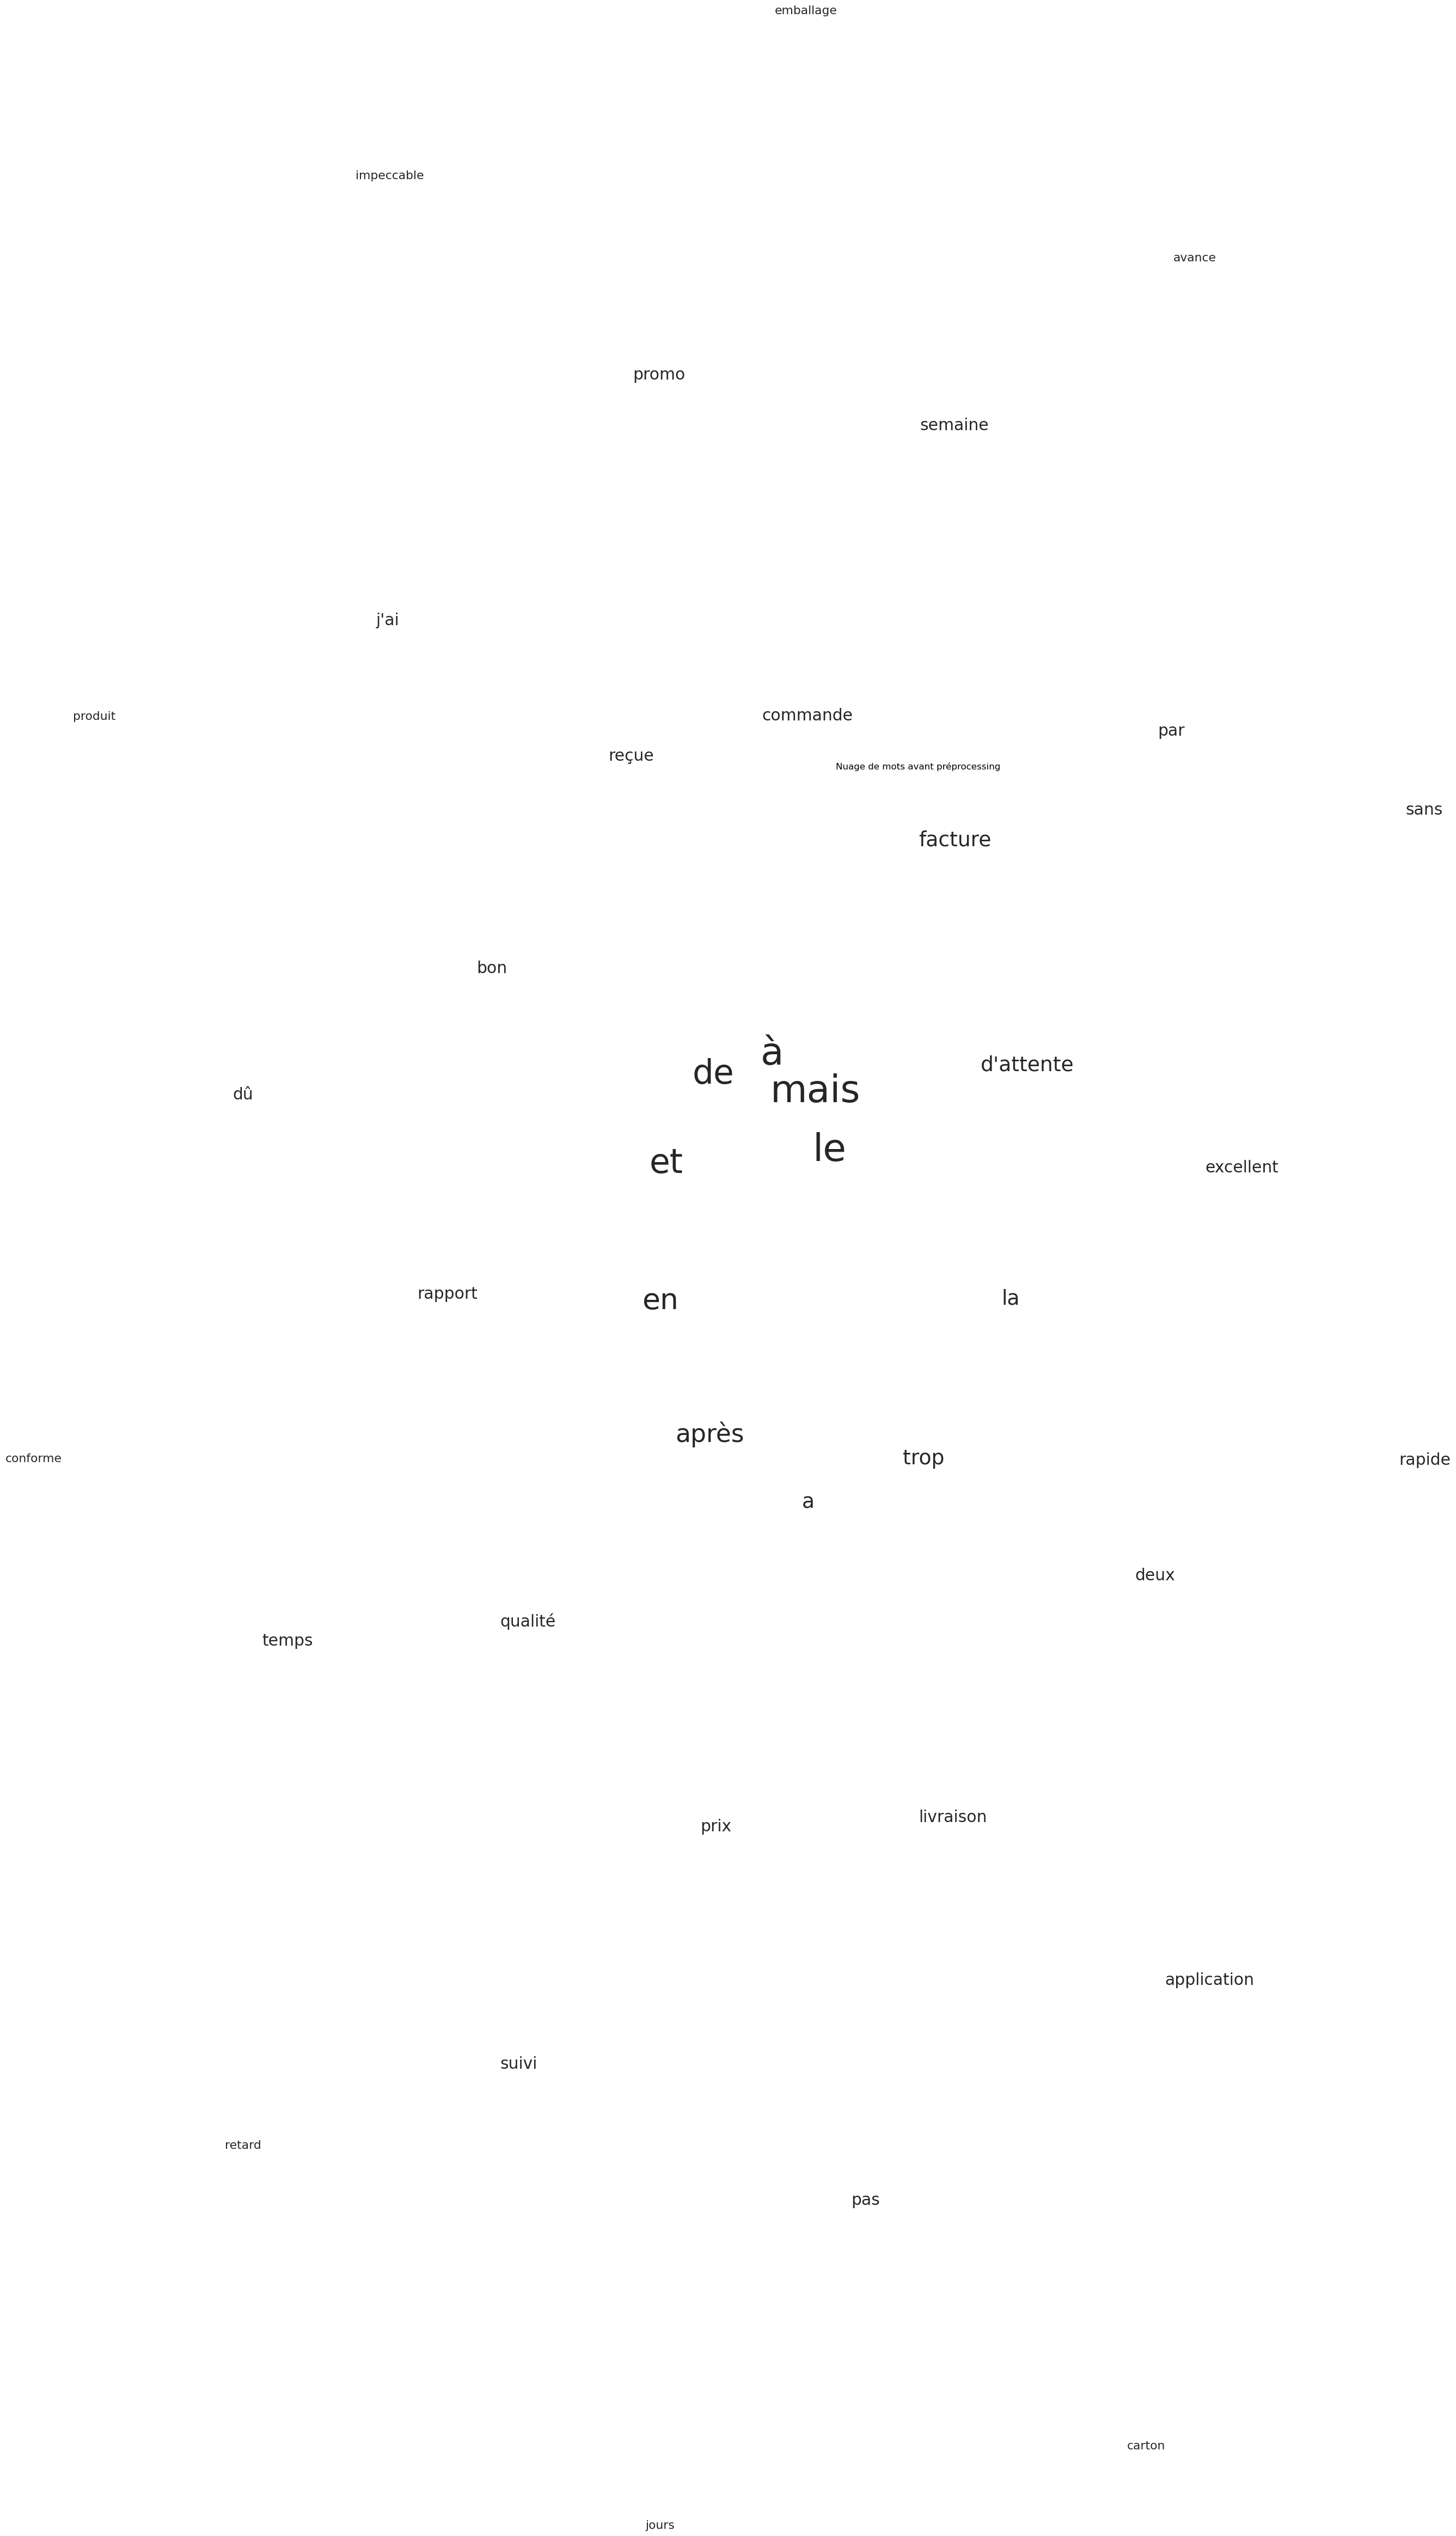

In [48]:
plt.figure(figsize=(6,10))
plot_pseudo_wordcloud(top_before, 'Avant préprocessing')
plt.title("Nuage de mots avant préprocessing")
plt.show()

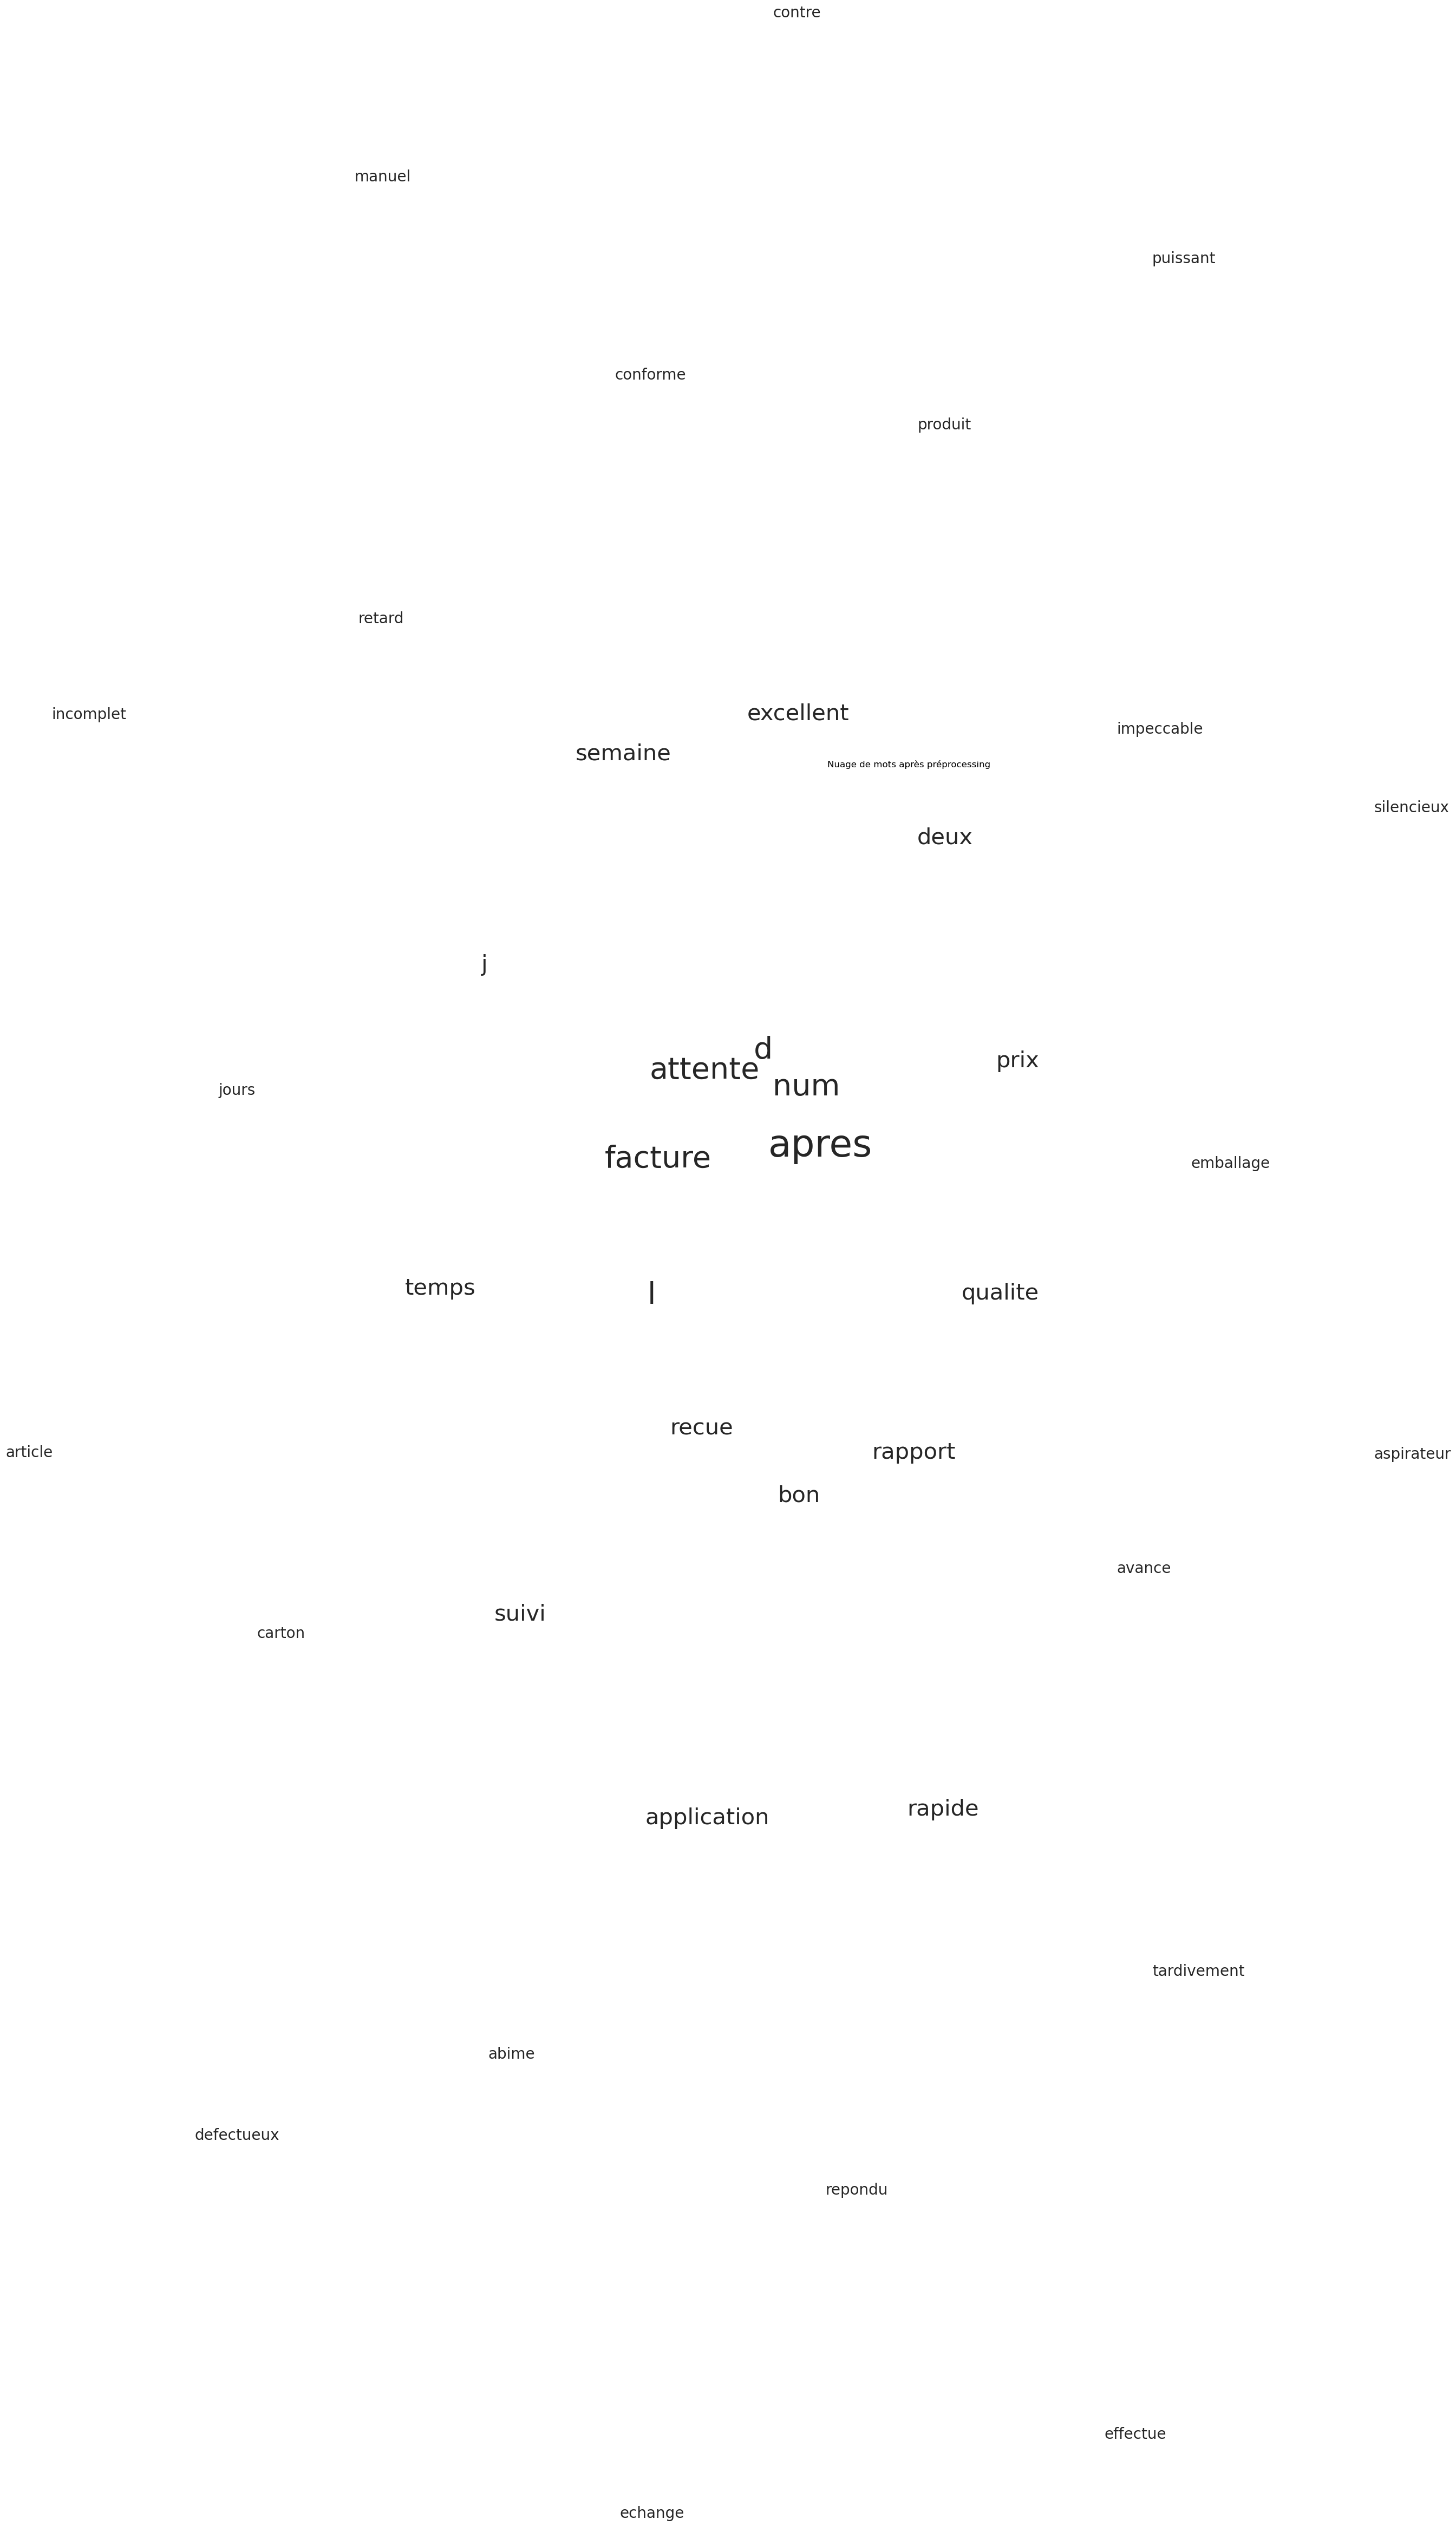

In [49]:
plt.figure(figsize=(6,10))
plot_pseudo_wordcloud(top_after,  'Après préprocessing')
plt.title("Nuage de mots après préprocessing")
plt.show()

## 6) (Option) Sauvegarde/Rechargement des corpus dictionnaires

In [ ]:
def save_dict_tokens(dct, path):
    with open(path, 'w', encoding='utf-8') as f:
        json.dump({str(k): v for k, v in dct.items()}, f, ensure_ascii=False, indent=2)

def load_dict_tokens(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return {int(k): v for k, v in data.items()}

save_dict_tokens(corpus_chars, 'data/corpus_chars.json')
save_dict_tokens(corpus_words, 'data/corpus_words.json')
save_dict_tokens(corpus_bpe,   'data/corpus_bpe.json')

print('Fichiers sauvegardés:', os.path.exists('data/corpus_chars.json'), os.path.exists('data/corpus_words.json'), os.path.exists('data/corpus_bpe.json'))



## Exercices
- Ajuster les **stopwords de domaine** (ex.: `sav`, `promo`, `commande`, `livraison`) et observer l'effet sur le pseudo‑WordCloud.
- **Conserver les nombres** (désactiver `NUMBER_RE.sub`) pour voir la présence de durées/quantités.
- Comparer avec/sans **suppression des accents** (`strip_accents`).
- Varier `num_merges` en BPE pour obtenir plus/moins de sous‑mots.
- Construire le nuage des mots avec la librairie wordcloud
